# Using FIFOQueue for loading images from paths in background (Tensorflow)

## Necesary imports

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import unittest
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import data_flow_ops

## Load example dictionary data

Dictionary estructure is as follow
```python
{
'class_id0': ['img_path0_class_id0','img_path1_class_id0' ...]
'class_id1': ['img_path0_class_id1','img_path1_class_id1' ...]
...
}
```

In [2]:
DATASET_PATH_NPY='/home/dpcabo/workspace/FaceIDNNv3-dev/MFv2_Train_short.npy'
dataset = np.load(DATASET_PATH_NPY)[()]

### Initialize Tensorflow session ( Configure gpu to allow growth and limit GPU memory to 10%)

It is very important **use allow_growth=True flag** to avoid tensorflow uses all gpu resurces in machine, **specially in a server machines**

In [3]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1, allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Define worflow variables

In [4]:
batch_size = 6 ## Batchsize for dequeuing
elements_to_enqeueue=30  ## Number of elements to enqueue in each iteration
images_size=160

Define Tensorflow placeholders to send variables from python to tensorflow session

In [5]:
batch_size_placeholder = tf.placeholder(tf.int32, name='batch_size')
image_paths_placeholder = tf.placeholder(tf.string, shape=(None, 1), name='image_paths')
labels_placeholder = tf.placeholder(tf.int64, shape=(None, 1), name='labels')

### Define function to create a queue and enqueue / dequeue operations

In [6]:

def QueueDataLoader(image_paths_placeholder, labels_placeholder, batch_size_placeholder,
                    image_size, batch_size,n_threads=4):
    
    input_queue = data_flow_ops.FIFOQueue(capacity=100000,
                                dtypes=[tf.string, tf.int64],
                                shapes=[(1,), (1,)],
                                shared_name=None, name=None)
    enqueue_op = input_queue.enqueue_many([image_paths_placeholder, labels_placeholder])
    images_and_labels=[]
    for _ in range(n_threads):
        filename,label = input_queue.dequeue()
        file_contents = tf.read_file(filename[0])
        image = tf.image.decode_jpeg(file_contents, channels=3) ## Here we use jpg images ( there are others tf.image.decode format funcs )
        image = tf.image.central_crop(image,0.8) ## Image preproces operations. For example, crop the % center of the image
        image = tf.image.resize_images(image,[image_size, image_size]) ## " , resize image to image_size
        image.set_shape((image_size, image_size, 3)) ## Specify the image shape. Wouldn't be necesssary
        #image = tf.image.per_image_standardization(image) ## Apply per_image_standarization
        images_and_labels.append([[image],label])
    
    ## Create merge data in batchs ( this enable tensorflow to perform operations in backgorund threads)
    image_batch, labels_batch = tf.train.batch_join(
        images_and_labels, batch_size=batch_size_placeholder,
        shapes=[(image_size, image_size, 3), ()], enqueue_many=True,
        capacity=4 * n_threads * batch_size,  ## Capacity is specified greather than batch size to be sure that there will be always elements in queue
        allow_smaller_final_batch=True)
    image_batch = tf.identity(image_batch, 'image_batch')
    image_batch = tf.identity(image_batch, 'input')
    labels_batch = tf.identity(labels_batch, 'label_batch')
    
    return enqueue_op,image_batch,labels_batch

### Crete queue and operations

In [7]:
enqueue_operation, batch_images,batch_labels = QueueDataLoader(image_paths_placeholder,labels_placeholder,batch_size_placeholder,images_size,batch_size)

### Start backgorund threads and threads coordinator

In [8]:
coord = tf.train.Coordinator()
ths = tf.train.start_queue_runners(coord=coord, sess=sess)

### Enqueue some images

In [9]:
images_array=[]
labels_array=[]

for class_id, image_paths in dataset.iteritems():
    labels_array.append(class_id)
    images_array.append(image_paths[0])
    if len(labels_array) >= elements_to_enqeueue:
        break

labels = np.expand_dims(np.array(labels_array),1)
image_paths = np.expand_dims(np.array(images_array),1)

feed_dict = {
    image_paths_placeholder: image_paths,
    labels_placeholder: labels
}
sess.run(enqueue_operation,feed_dict=feed_dict)    

### Dequeue a batch of images and labels

In [10]:
feed_dict={
    batch_size_placeholder: batch_size
}
images, labs = sess.run([batch_images,batch_labels], feed_dict=feed_dict)

### Visualize batch of preprocessed images 

<IPython.core.display.Javascript object>


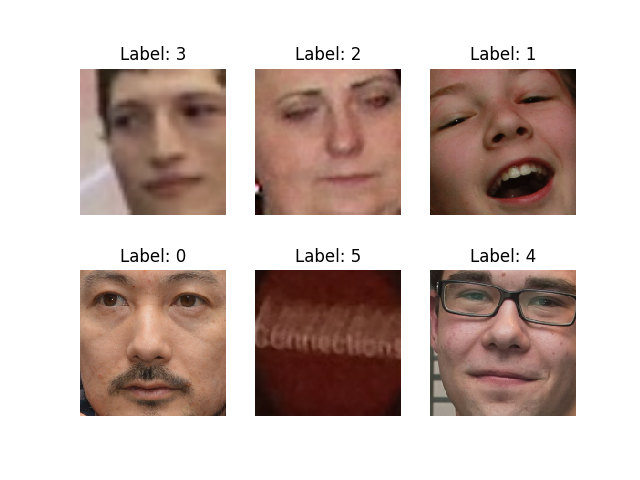

0 0
0 1
0 2
1 0
1 1
1 2


In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt
import operator
f,arr = plt.subplots(2,3)

for i in range(batch_size):
    x_idx = int(np.floor(i/3))
    y_idx = operator.mod(i,3)
    print x_idx, y_idx
    arr[x_idx,y_idx].imshow(images[i,...].astype(np.uint8))
    arr[x_idx,y_idx].set_title('Label: %d' % labs[i])
    arr[x_idx,y_idx].axis('off')
plt.show()

### Finalize background threads and stop coordinator

In [12]:
coord.request_stop()
coord.join(ths,stop_grace_period_secs=5,ignore_live_threads=True)

INFO:tensorflow:Coordinator stopped with threads still running: Thread-4 Thread-7 Thread-5 Thread-6


## Close Tensorflow session

In [13]:
sess.close()

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/opt/miniconda2/envs/kerasTF_py27/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/opt/miniconda2/envs/kerasTF_py27/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/opt/miniconda2/envs/kerasTF_py27/lib/python2.7/site-packages/tensorflow/python/training/queue_runner_impl.py", line 254, in _run
    coord.request_stop(e)
  File "/opt/miniconda2/envs/kerasTF_py27/lib/python2.7/site-packages/tensorflow/python/training/coordinator.py", line 211, in request_stop
    six.reraise(*sys.exc_info())
  File "/opt/miniconda2/envs/kerasTF_py27/lib/python2.7/site-packages/tensorflow/python/training/queue_runner_impl.py", line 238, in _run
    enqueue_callable()
  File "/opt/miniconda2/envs/kerasTF_py27/lib/python2.7/site-packages/tensorflow/python/client/session.py", line 1235, in _single_operation_run
    target_list_as_strings, status, Non